In [1]:
import os, sys
sys.path.append( os.path.join('..', '..'))

import numpy as np
from scipy.constants import e, k, epsilon_0

# my own modules
from src.solver import Poisson_solver1D as solver1D
from src.solver import updater
from src.model.carrier_density import *
from src.model import density_of_state as DOS
from src.model.position import get_1D_position_mask

# Si - GaAs Junction (Heterojunction)

In [2]:
""" constants setting """
T = 300
kT_q = k*T/e

materials = ['GaAs', 'Si']
x_range = np.array( [ [-np.inf, 0], [0, np.inf] ] )

x = np.linspace(-1e-4, 1e-4, 1000) # cm
Na = dope_constant_acceptor(x = x, Nd = 1e16, x_range=x_range[0]) # cm^-3
Nd = dope_constant_donor(x = x, Na = 1e16, x_range=x_range[1]) # cm^-3
epsilon_q =  epsilon_0 * 1e-2 * get_episolon_r_at_different_x(x = x, materials=materials, x_range=x_range) / e 

In [3]:
""" condition/material """
def cal_Ec_from_V(x, V, q = 1.0):
    Ec = -q*V
    Ec[x < 0] += EA['Si'] - EA['GaAs']
    return Ec
def cal_Ev_from_V(x, V, q = 1.0):
    Ec = cal_Ec_from_V(x, V, q=q)
    return cal_Ev_from_Ec_at_different_x(x = x, Ec = Ec, materials = materials, x_range = x_range)
def cal_n(x, V):
    Ec = cal_Ec_from_V(x, V)
    return cal_electron_density_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_p(x, V):
    Ev = cal_Ev_from_V(x, V)
    return cal_hole_density_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dn_dV(x, V):
    Ec = cal_Ec_from_V(x, V)
    return -cal_dn_dEc_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dp_dV(x, V):
    Ev = cal_Ev_from_V(x, V)
    return -cal_dp_dEv_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)

def cal_total_charge_density(x, V):
    N  = Nd  - Na  + cal_p(x,  V)  - cal_n(x,  V)
    return N
def cal_dtotal_charge_density_dV(x, V):
    dN_dV  = cal_dp_dV(x,  V)  - cal_dn_dV(x,  V)
    return dN_dV

def src_fun(x, V):
    return to_poisson_source(charge_density = cal_total_charge_density(x, V), epsilon=epsilon_q)
def d_src_dV_fun(x, V):
    return to_poisson_source(charge_density = cal_dtotal_charge_density_dV(x, V), epsilon=epsilon_q)  

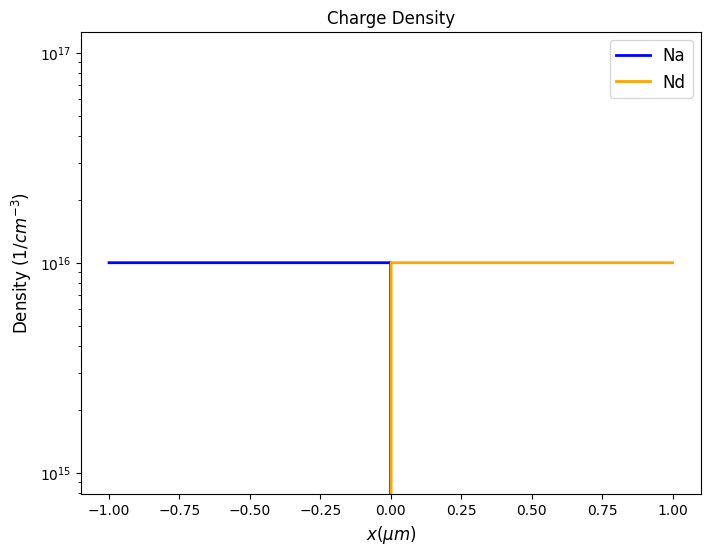

In [4]:
""" plot doping """
solver1D.plot_carrier_density_1D(x, Na = Na, Nd = Nd);

In [5]:
""" solve Poisson equation """
V_updater = updater.AdagradUpdater(size = x.size, lr=0.1)
V = solver1D.solve_Poisson_1D(x = x, max_iter=2000, src_fun = src_fun, dsrc_dV_fun = d_src_dV_fun, V_updater = V_updater)

  0%|          | 0/2000 [00:00<?, ?it/s]

 63%|██████▎   | 1269/2000 [00:03<00:02, 359.19it/s]


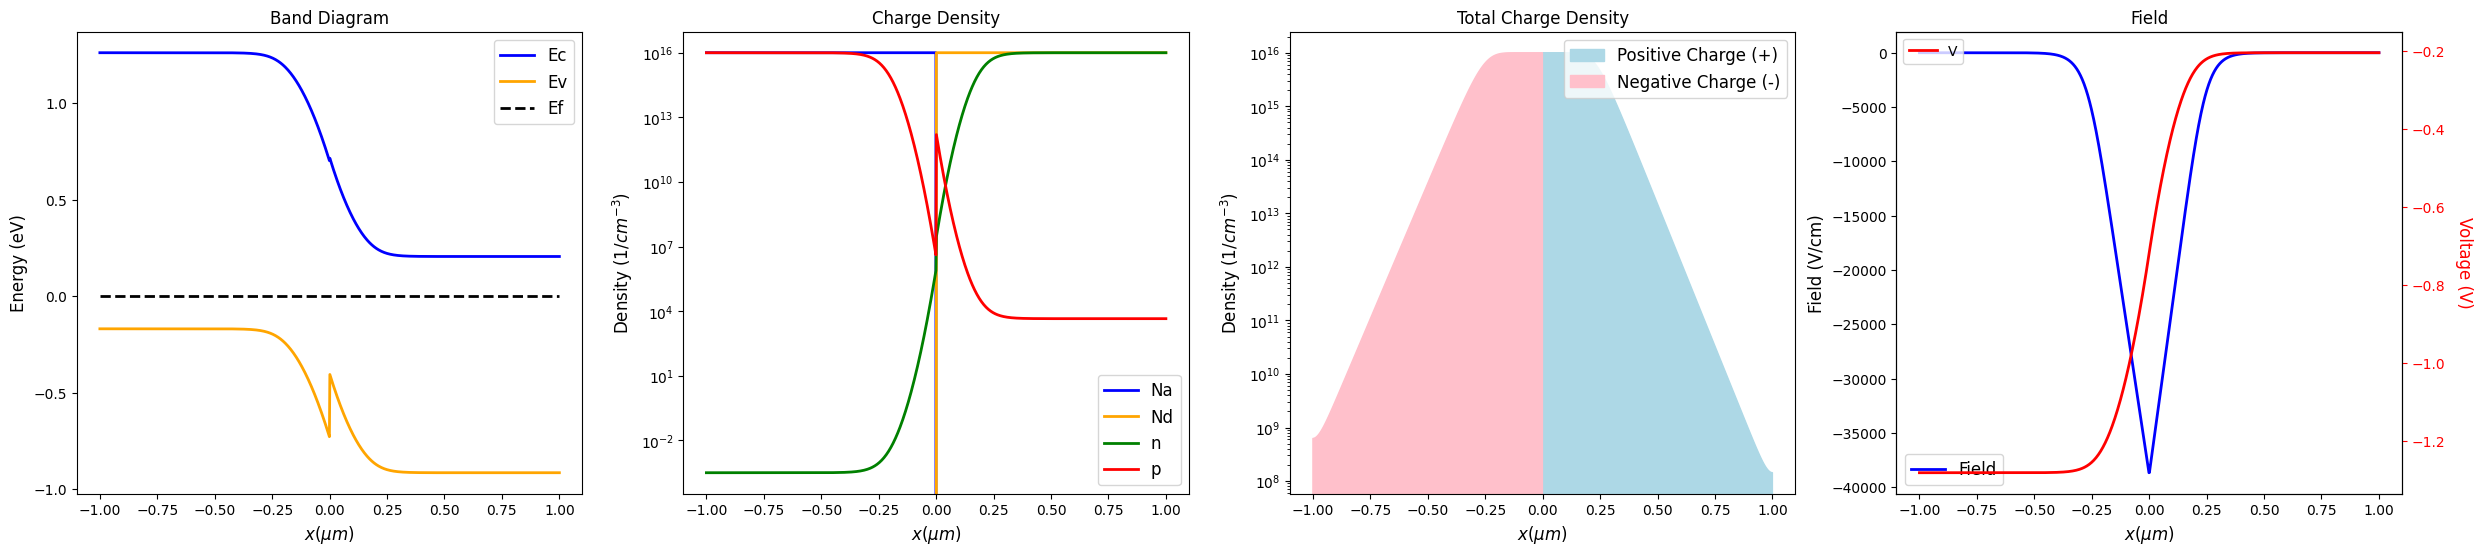

In [6]:
""" plot results """
n = cal_n(x, V)
p = cal_p(x, V)
Ec = cal_Ec_from_V(x, V)
Ev = cal_Ev_from_V(x, V)
total_charge_density = cal_total_charge_density(x, V)
Field = cal_electric_field(x, V)

solver1D.plot_Poisson_1D(x=x, V=V, n=n, p=p, total_charge_density=total_charge_density, Ec=Ec, Ev=Ev, Field=Field, Na=Na, Nd=Nd);

# Si - GaAs Junction (Heterojunction) + Dit (Acceptor Like)

In [7]:
""" constants setting """
T = 300
kT_q = k*T/e

materials = ['GaAs', 'Si']
x_range = np.array( [ [-np.inf, 0], [0, np.inf] ] )

x = np.linspace(-1e-4, 1e-4, 1000) # cm
Na = dope_constant_acceptor(x = x, Nd = 1e16, x_range=[-np.inf,0]) # cm^-3
Nd = dope_constant_donor(x = x, Na = 1e16, x_range=[0,np.inf]) # cm^-3
epsilon_q =  epsilon_0 * 1e-2 * get_episolon_r_at_different_x(x = x, materials=materials, x_range=x_range) / e 

dit_x_range = np.array([[0, 0.05e-4]])
N_dit = 3e16 # cm^-2
E_dit_sigma = 0.02 # eV

In [8]:
""" condition/material """
def cal_Ec_from_V(x, V, q = 1.0):
    Ec = -q*V
    Ec[x < 0] += EA['Si'] - EA['GaAs']
    return Ec
def cal_Ev_from_V(x, V, q = 1.0):
    Ec = cal_Ec_from_V(x, V, q=q)
    return cal_Ev_from_Ec_at_different_x(x = x, Ec = Ec, materials = materials, x_range = x_range)
def cal_n(x, V):
    Ec = cal_Ec_from_V(x, V)
    return cal_electron_density_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_p(x, V):
    Ev = cal_Ev_from_V(x, V)
    return cal_hole_density_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dn_dV(x, V):
    Ec = cal_Ec_from_V(x, V)
    return -cal_dn_dEc_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dp_dV(x, V):
    Ev = cal_Ev_from_V(x, V)
    return -cal_dp_dEv_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)

def cal_E_dit_mean(x, V):
    E_dit_mean = np.zeros_like(x)
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)

    Ec = cal_Ec_from_V(x[mask], V[mask])
    E_dit_mean[mask] = Ec - 0.8*Eg['Si']
    return E_dit_mean
def cal_Dit(x, V):
    Dit = np.zeros_like(x)
    # Dit between surfacee and 0.05 um
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    
    # Dit position
    E_dit_mean = cal_E_dit_mean(x[mask], V[mask])

    # integraion function
    dos_fun = DOS.gaussian_density_of_state
    E_min, E_max = E_dit_mean - 3*E_dit_sigma, E_dit_mean + 3*E_dit_sigma
    Dit[mask] = N_dit * 0.5 -cal_charge_density_from_dos_fun( dos_fun, Ef = 0.0, kT = kT_q, E_min = E_min, E_max = E_max, E0 = E_dit_mean, sigma = E_dit_sigma, N = N_dit)
    return Dit
def cal_dDit_dV(x, V):
    dDit_dEc = np.zeros_like(x)
    # Dit between surfacee and 0.05 um
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    
    # Dit at ceter of bandgap
    E_dit_mean = cal_E_dit_mean(x[mask], V[mask])

    # integraion function
    d_dos_fun = DOS.d_gaussian_density_of_state_dE0
    E_min, E_max = E_dit_mean - 3*E_dit_sigma, E_dit_mean + 3*E_dit_sigma
    dDit_dEc[mask] = - cal_d_charge_density_from_d_dos_fun( d_dos_fun=d_dos_fun, Ef = 0.0, kT = kT_q, E_min = E_min, E_max = E_max, E0 = E_dit_mean, sigma = E_dit_sigma, N = N_dit)
    return -dDit_dEc

def cal_total_charge_density(x, V):
    N  = Nd - Na  + cal_p(x,  V)  - cal_n(x,  V)

    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    N[mask] += cal_Dit(x[mask], V[mask])
    return N
def cal_dtotal_charge_density_dV(x, V):
    dN_dV = cal_dp_dV(x, V) - cal_dn_dV(x, V)
    
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    dN_dV[mask] += cal_dDit_dV(x[mask], V[mask])
    return dN_dV

def src_fun(x, V):
    return to_poisson_source(charge_density = cal_total_charge_density(x, V), epsilon=epsilon_q)
def d_src_dV_fun(x, V):
    return to_poisson_source(charge_density = cal_dtotal_charge_density_dV(x, V), epsilon=epsilon_q)  


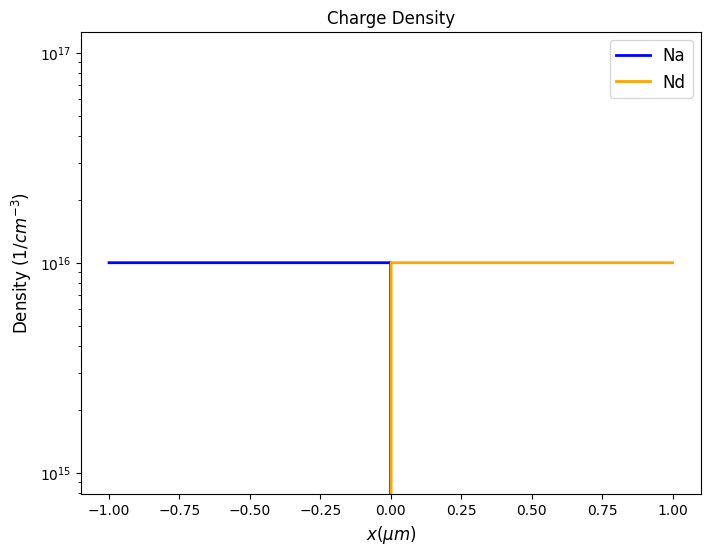

In [9]:
""" plot doping """
solver1D.plot_carrier_density_1D(x, Na = Na, Nd = Nd);

In [10]:
""" solve Poisson equation """
V_updater = updater.AdagradUpdater(size = x.size, lr=0.1)
V = solver1D.solve_Poisson_1D(x = x, max_iter=3000, src_fun = src_fun, dsrc_dV_fun = d_src_dV_fun, V_updater = V_updater, tol=1e-10)

 75%|███████▍  | 2245/3000 [00:09<00:03, 236.24it/s]


<Axes: title={'center': 'Band Diagram'}, xlabel='$x (\\mu m)$', ylabel='Energy (eV)'>

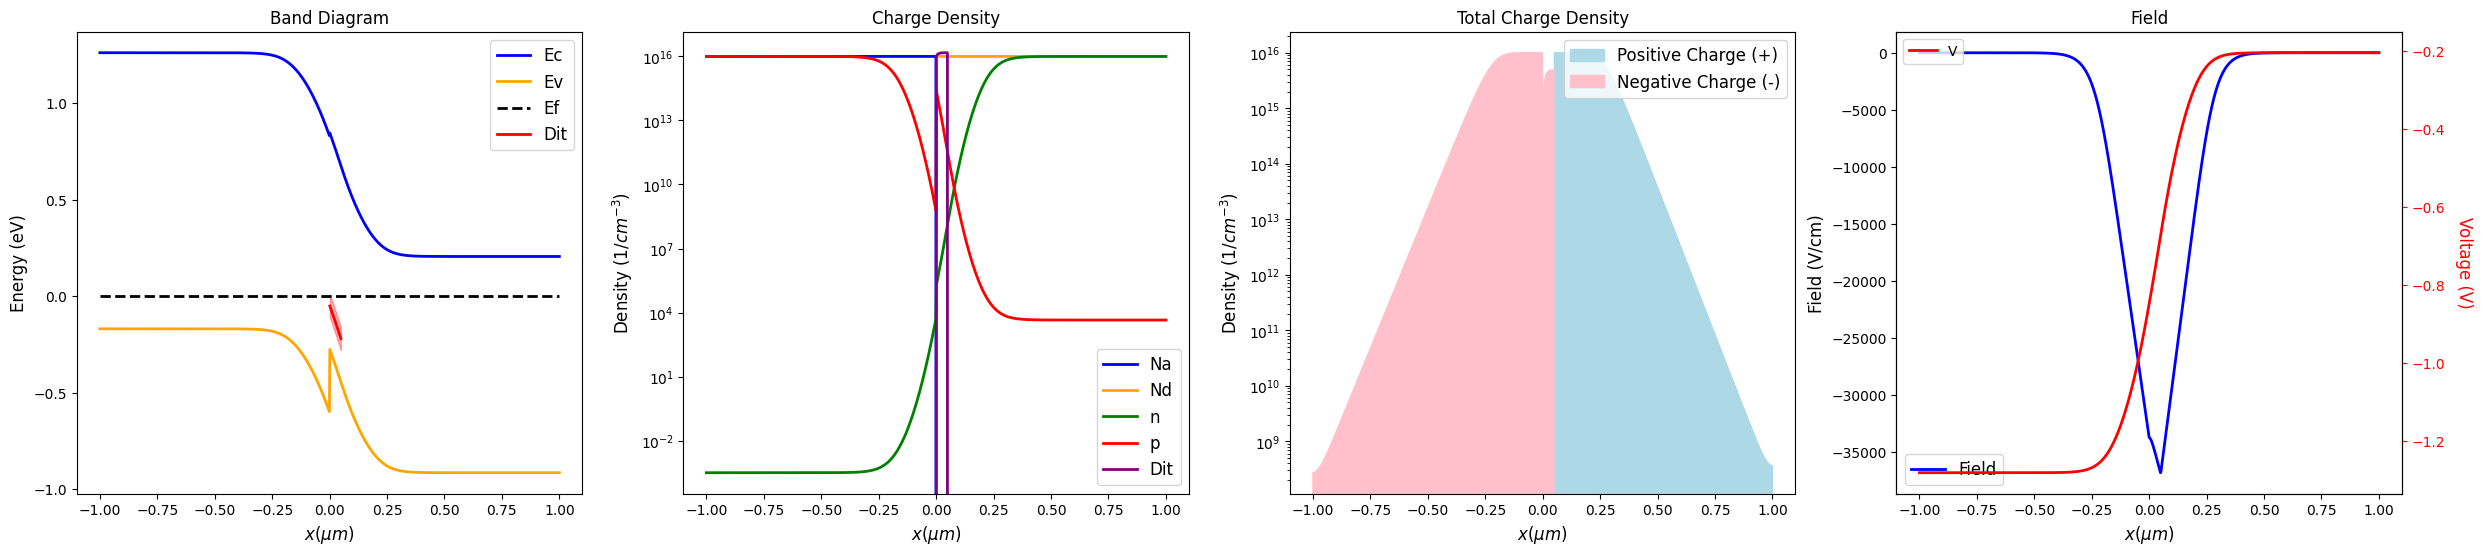

In [11]:
""" plot results """
n = cal_n(x, V)
p = cal_p(x, V)
Ec = cal_Ec_from_V(x, V)
Ev = cal_Ev_from_V(x, V)
total_charge_density = cal_total_charge_density(x, V)
Field = cal_electric_field(x, V)

ax = solver1D.plot_Poisson_1D(x=x, V=V, n=n, p=p, total_charge_density=total_charge_density, Ec=Ec, Ev=Ev, Field=Field, Na=Na, Nd=Nd, Dit=cal_Dit(x, V));

mask = np.bitwise_and( x>0, x<0.05e-4)
E_dit_mean = cal_E_dit_mean(x[mask], V[mask])
solver1D.plot_gaussian_Dit(x[mask], E_dit_mean=E_dit_mean, E_dit_sigma=E_dit_sigma, ax=ax[0])

# Si - GaAs Junction (Heterojunction) + Dit (Donor Like)

In [12]:
""" constants setting """
T = 300
kT_q = k*T/e

materials = ['GaAs', 'Si']
x_range = np.array( [ [-np.inf, 0], [0, np.inf] ] )

x = np.linspace(-1e-4, 1e-4, 1000) # cm
Na = dope_constant_acceptor(x = x, Nd = 1e16, x_range=[-np.inf,0]) # cm^-3
Nd = dope_constant_donor(x = x, Na = 1e16, x_range=[0,np.inf]) # cm^-3
epsilon_q =  epsilon_0 * 1e-2 * get_episolon_r_at_different_x(x = x, materials=materials, x_range=x_range) / e 


dit_x_range = np.array([[0, 0.05e-4]])
N_dit = 3e16 # cm^-2
E_dit_sigma = 0.02 # eV

In [13]:
""" condition/material """
def cal_Ec_from_V(x, V, q = 1.0):
    Ec = -q*V
    Ec[x < 0] += EA['Si'] - EA['GaAs']
    return Ec
def cal_Ev_from_V(x, V, q = 1.0):
    Ec = cal_Ec_from_V(x, V, q=q)
    return cal_Ev_from_Ec_at_different_x(x = x, Ec = Ec, materials = materials, x_range = x_range)
def cal_n(x, V):
    Ec = cal_Ec_from_V(x, V)
    return cal_electron_density_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_p(x, V):
    Ev = cal_Ev_from_V(x, V)
    return cal_hole_density_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dn_dV(x, V):
    Ec = cal_Ec_from_V(x, V)
    return -cal_dn_dEc_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dp_dV(x, V):
    Ev = cal_Ev_from_V(x, V)
    return -cal_dp_dEv_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)

def cal_E_dit_mean(x, V):
    E_dit_mean = np.zeros_like(x)
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)

    Ec = cal_Ec_from_V(x[mask], V[mask])
    E_dit_mean[mask] = Ec - 0.2*Eg['Si']
    return E_dit_mean

def cal_Dit(x, V):
    Dit = np.zeros_like(x)
    # Dit between surfacee and 0.05 um
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    
    # Dit position
    E_dit_mean = cal_E_dit_mean(x[mask], V[mask])

    # integraion function
    dos_fun = DOS.gaussian_density_of_state
    E_min, E_max = E_dit_mean - 3*E_dit_sigma, E_dit_mean + 3*E_dit_sigma
    Dit[mask] = N_dit * 0.5 -cal_charge_density_from_dos_fun( dos_fun, Ef = 0.0, kT = kT_q, E_min = E_min, E_max = E_max, E0 = E_dit_mean, sigma = E_dit_sigma, N = N_dit)
    return Dit
def cal_dDit_dV(x, V):
    dDit_dEc = np.zeros_like(x)
    # Dit between surfacee and 0.05 um
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    
    # Dit at ceter of bandgap
    E_dit_mean = cal_E_dit_mean(x[mask], V[mask])

    # integraion function
    d_dos_fun = DOS.d_gaussian_density_of_state_dE0
    E_min, E_max = E_dit_mean - 3*E_dit_sigma, E_dit_mean + 3*E_dit_sigma
    dDit_dEc[mask] = - cal_d_charge_density_from_d_dos_fun( d_dos_fun=d_dos_fun, Ef = 0.0, kT = kT_q, E_min = E_min, E_max = E_max, E0 = E_dit_mean, sigma = E_dit_sigma, N = N_dit)
    return -dDit_dEc

def cal_total_charge_density(x, V):
    N  = Nd - Na  + cal_p(x,  V)  - cal_n(x,  V)

    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    N[mask] += cal_Dit(x[mask], V[mask])
    return N
def cal_dtotal_charge_density_dV(x, V):
    dN_dV = cal_dp_dV(x, V) - cal_dn_dV(x, V)
    
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    dN_dV[mask] += cal_dDit_dV(x[mask], V[mask])
    return dN_dV

def src_fun(x, V):
    return to_poisson_source(charge_density = cal_total_charge_density(x, V), epsilon=epsilon_q)
def d_src_dV_fun(x, V):
    return to_poisson_source(charge_density = cal_dtotal_charge_density_dV(x, V), epsilon=epsilon_q)  

In [14]:
""" solve Poisson equation """
V_updater = updater.AdagradUpdater(size = x.size, lr=0.1)
V = solver1D.solve_Poisson_1D(x = x, max_iter=2000, src_fun = src_fun, dsrc_dV_fun = d_src_dV_fun, V_updater = V_updater)

 60%|██████    | 1202/2000 [00:04<00:03, 246.68it/s]


<Axes: title={'center': 'Band Diagram'}, xlabel='$x (\\mu m)$', ylabel='Energy (eV)'>

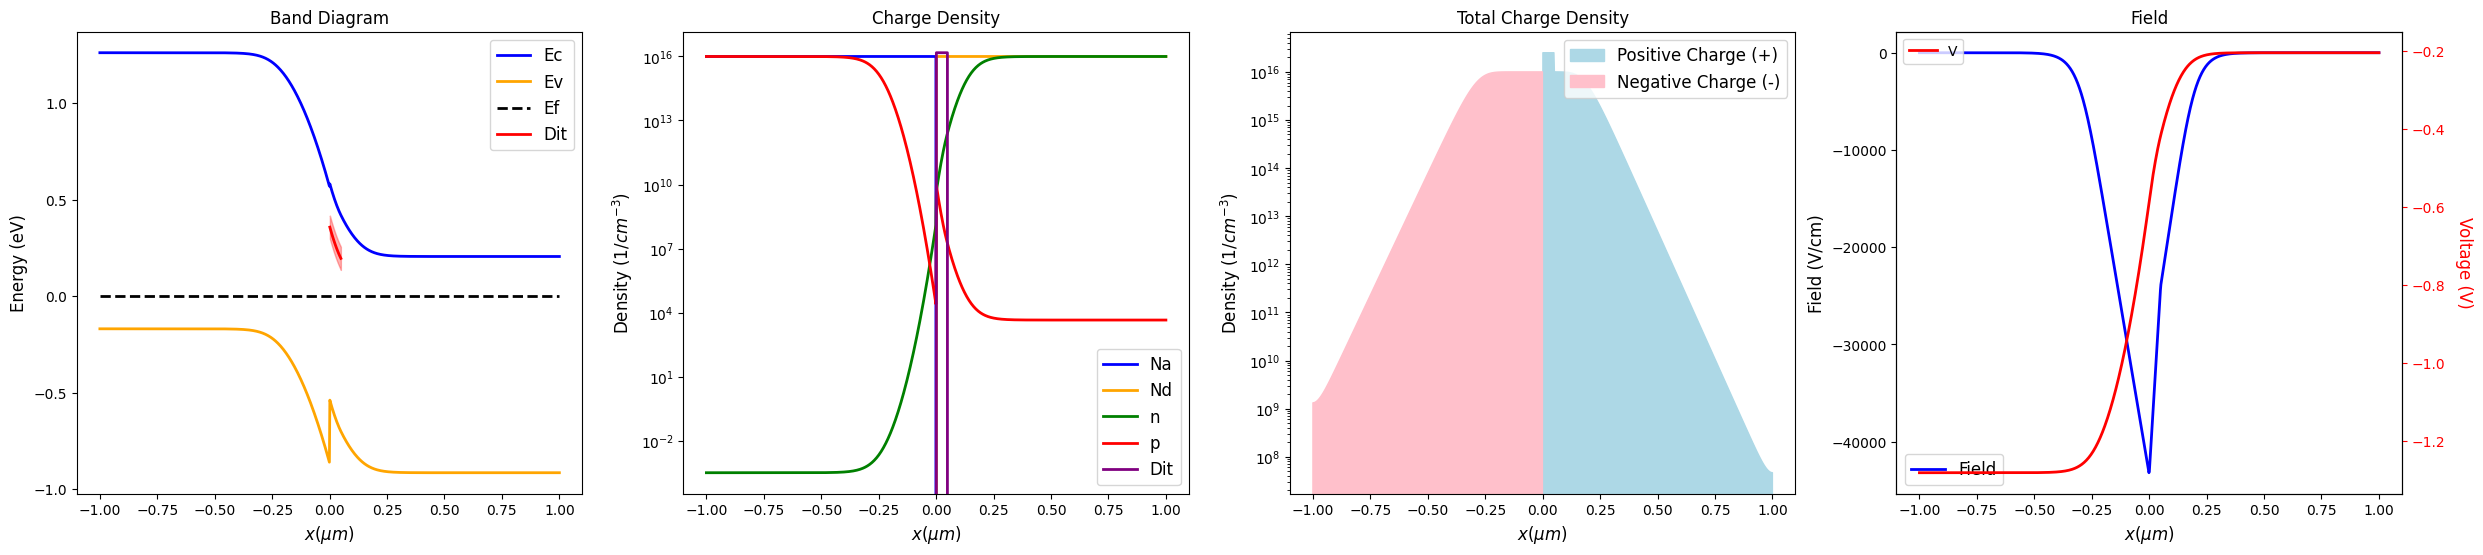

In [15]:
""" plot results """
n = cal_n(x, V)
p = cal_p(x, V)
Ec = cal_Ec_from_V(x, V)
Ev = cal_Ev_from_V(x, V)
total_charge_density = cal_total_charge_density(x, V)
Field = cal_electric_field(x, V)

ax = solver1D.plot_Poisson_1D(x=x, V=V, n=n, p=p, total_charge_density=total_charge_density, Ec=Ec, Ev=Ev, Field=Field, Na=Na, Nd=Nd, Dit=cal_Dit(x, V));

mask = np.bitwise_and( x>0, x<0.05e-4)
E_dit_mean = cal_E_dit_mean(x[mask], V[mask])
solver1D.plot_gaussian_Dit(x[mask], E_dit_mean=E_dit_mean, E_dit_sigma=E_dit_sigma, ax=ax[0])

# Si - GaAs Junction (Heterojunction) + Dit 

In [16]:
""" constants setting """
T = 300
kT_q = k*T/e

materials = ['GaAs', 'Si']
x_range = np.array( [ [-np.inf, 0], [0, np.inf] ] )

x = np.linspace(-1e-4, 1e-4, 1000) # cm
Na = dope_constant_acceptor(x = x, Nd = 1e16, x_range=[-np.inf,0]) # cm^-3
Nd = dope_constant_donor(x = x, Na = 1e16, x_range=[0,np.inf]) # cm^-3
epsilon_q =  epsilon_0 * 1e-2 * get_episolon_r_at_different_x(x = x, materials=materials, x_range=x_range) / e 

dit_x_range = np.array([[0, 0.05e-4]])
N_dit = 4e16 # cm^-2
E_dit_sigma = 0.03 # eV

In [17]:
""" condition/material """
def cal_Ec_from_V(x, V, q = 1.0):
    Ec = -q*V
    Ec[x < 0] += EA['Si'] - EA['GaAs']
    return Ec
def cal_Ev_from_V(x, V, q = 1.0):
    Ec = cal_Ec_from_V(x, V, q=q)
    return cal_Ev_from_Ec_at_different_x(x = x, Ec = Ec, materials = materials, x_range = x_range)
def cal_n(x, V):
    Ec = cal_Ec_from_V(x, V)
    return cal_electron_density_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_p(x, V):
    Ev = cal_Ev_from_V(x, V)
    return cal_hole_density_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dn_dV(x, V):
    Ec = cal_Ec_from_V(x, V)
    return -cal_dn_dEc_at_different_x(x = x, Ec = Ec, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)
def cal_dp_dV(x, V):
    Ev = cal_Ev_from_V(x, V)
    return -cal_dp_dEv_at_different_x(x = x, Ev = Ev, Ef = 0.0, kT = kT_q, materials = materials, x_range = x_range)

def cal_E_dit_mean(x, V):
    E_dit_mean = np.zeros_like(x)
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)

    Ec = cal_Ec_from_V(x[mask], V[mask])
    E_dit_mean[mask] = Ec - 0.5*Eg['Si']
    return E_dit_mean

def cal_Dit(x, V):
    Dit = np.zeros_like(x)
    # Dit between surfacee and 0.05 um
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    
    # Dit position
    E_dit_mean = cal_E_dit_mean(x[mask], V[mask])

    # integraion function
    dos_fun = DOS.gaussian_density_of_state
    E_min, E_max = E_dit_mean - 3*E_dit_sigma, E_dit_mean + 3*E_dit_sigma
    Dit[mask] = N_dit * 0.5 -cal_charge_density_from_dos_fun( dos_fun, Ef = 0.0, kT = kT_q, E_min = E_min, E_max = E_max, E0 = E_dit_mean, sigma = E_dit_sigma, N = N_dit)
    return Dit
def cal_dDit_dV(x, V):
    dDit_dEc = np.zeros_like(x)
    # Dit between surfacee and 0.05 um
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    
    # Dit at ceter of bandgap
    E_dit_mean = cal_E_dit_mean(x[mask], V[mask])

    # integraion function
    d_dos_fun = DOS.d_gaussian_density_of_state_dE0
    E_min, E_max = E_dit_mean - 3*E_dit_sigma, E_dit_mean + 3*E_dit_sigma
    dDit_dEc[mask] = - cal_d_charge_density_from_d_dos_fun( d_dos_fun=d_dos_fun, Ef = 0.0, kT = kT_q, E_min = E_min, E_max = E_max, E0 = E_dit_mean, sigma = E_dit_sigma, N = N_dit)
    return -dDit_dEc

def cal_total_charge_density(x, V):
    N  = Nd - Na  + cal_p(x,  V)  - cal_n(x,  V)

    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    N[mask] += cal_Dit(x[mask], V[mask])
    return N
def cal_dtotal_charge_density_dV(x, V):
    dN_dV = cal_dp_dV(x, V) - cal_dn_dV(x, V)
    
    mask = get_1D_position_mask(x = x, x_range = dit_x_range)
    dN_dV[mask] += cal_dDit_dV(x[mask], V[mask])
    return dN_dV

def src_fun(x, V):
    return to_poisson_source(charge_density = cal_total_charge_density(x, V), epsilon=epsilon_q)
def d_src_dV_fun(x, V):
    return to_poisson_source(charge_density = cal_dtotal_charge_density_dV(x, V), epsilon=epsilon_q)  


In [18]:
""" solve Poisson equation """
V_updater = updater.AdagradUpdater(size = x.size, lr=0.1)
V = solver1D.solve_Poisson_1D(x = x, max_iter=10000, src_fun = src_fun, dsrc_dV_fun = d_src_dV_fun, V_updater = V_updater)

 12%|█▏        | 1197/10000 [00:04<00:35, 249.39it/s]


<Axes: title={'center': 'Band Diagram'}, xlabel='$x (\\mu m)$', ylabel='Energy (eV)'>

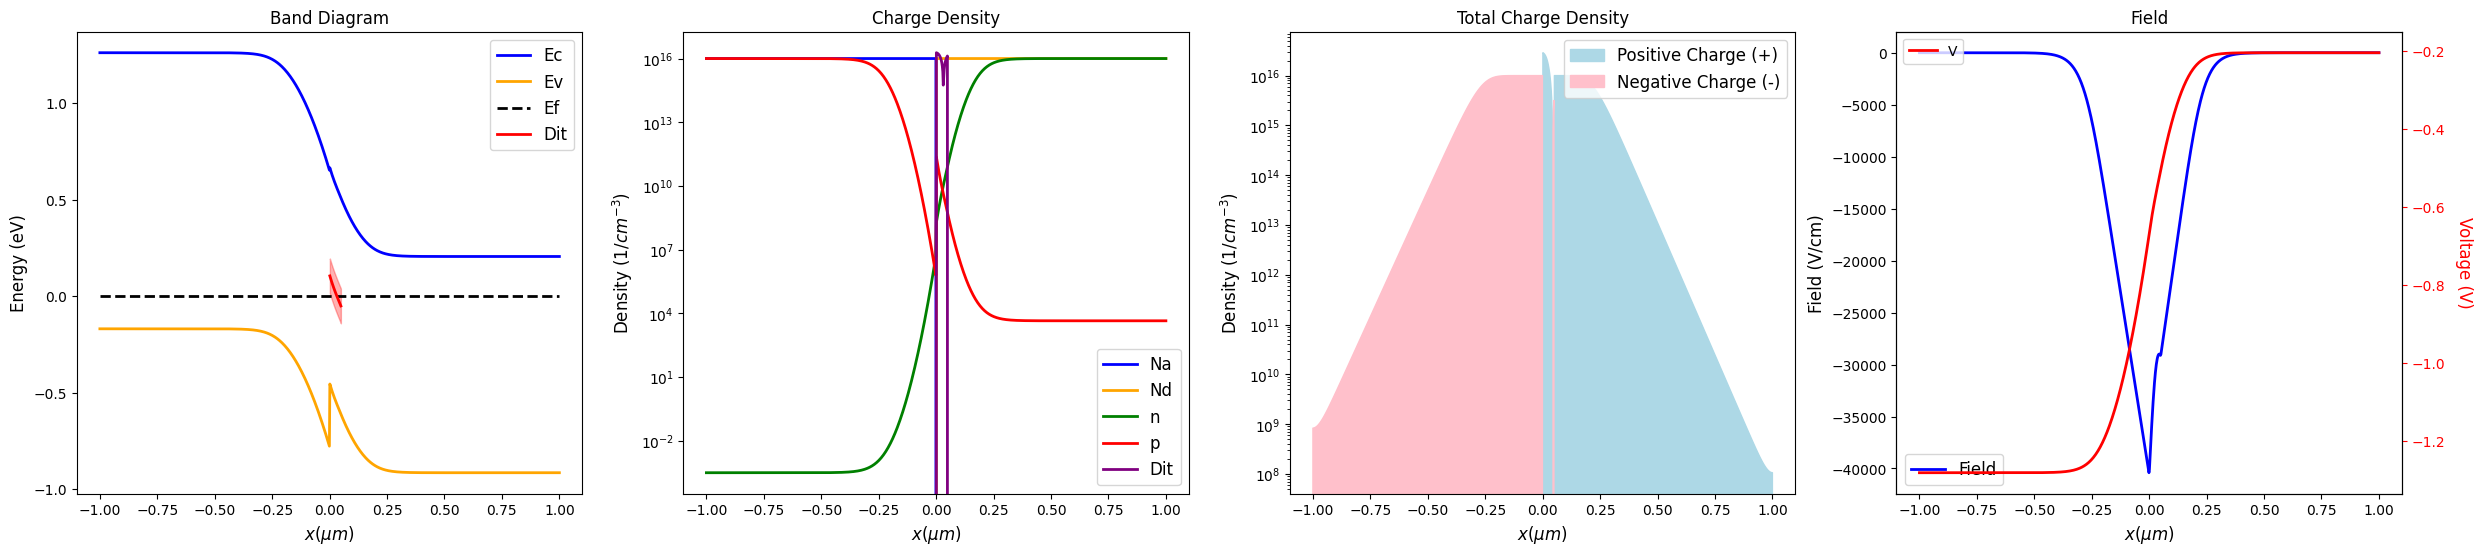

In [19]:
""" plot results """
n = cal_n(x, V)
p = cal_p(x, V)
Ec = cal_Ec_from_V(x, V)
Ev = cal_Ev_from_V(x, V)
total_charge_density = cal_total_charge_density(x, V)
Field = cal_electric_field(x, V) 

ax = solver1D.plot_Poisson_1D(x=x, V=V, n=n, p=p, total_charge_density=total_charge_density, Ec=Ec, Ev=Ev, Field=Field, Na=Na, Nd=Nd, Dit=cal_Dit(x, V));

mask = np.bitwise_and( x>0, x<0.05e-4)
E_dit_mean = cal_E_dit_mean(x[mask], V[mask])
solver1D.plot_gaussian_Dit(x[mask], E_dit_mean=E_dit_mean, E_dit_sigma=E_dit_sigma, ax=ax[0])
